# Assignment 2 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

___

In [19]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
import numpy as np
import tensorflow as tf
import random
import os

seed = 42  # You can choose any number

# Set seed for built-in Python
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for TensorFlow
tf.random.set_seed(seed)

# Optional: for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # This is optional and may not be necessary for all TensorFlow versions

In [21]:
#importing the data labels (main+extra)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("labels_main columns:\n", labels_main.head())
print("\nlabels_extra columns:\n", labels_extra.head())

labels_main columns:
    InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

labels_extra columns:
    InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


In [22]:
#checking the data types
print("\nlabels_main dtypes:\n", labels_main.dtypes)
print("\nlabels_extra dtypes:\n", labels_extra.dtypes)


labels_main dtypes:
 InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

labels_extra dtypes:
 InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object


In [23]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")

Total Numer of Images: 20280


In [24]:
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Images in labels_main but missing from patch_images folder:", csv_images_set - images_set)
print("Images in patch_images folder but missing from labels_main:", images_set - csv_images_set)
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: set()
Images in patch_images folder but missing from labels_main: {'19984.png', '11404.png', '16214.png', '6595.png', '2205.png', '15218.png', '11442.png', '10453.png', '21831.png', '7421.png', '10853.png', '22170.png', '7440.png', '14577.png', '22099.png', '16211.png', '6906.png', '6604.png', '7045.png', '11074.png', '2128.png', '21511.png', '10814.png', '12899.png', '9600.png', '2974.png', '20804.png', '5144.png', '2772.png', '12306.png', '19476.png', '22131.png', '12362.png', '21347.png', '14550.png', '6602.png', '2858.png', '10648.png', '10575.png', '11099.png', '11563.png', '1664.png', '15343.png', '5142.png', '12817.png', '19617.png', '13165.png', '14232.png', '10567.png', '19128.png', '21630.png', '12924.png', '3723.png', '2947.png', '7124.png', '15517.png', '6321.png', '7570.png', '1849.png', '2244.png', '15997.png', '13004.png', '9544.png', '12425.png', '16371.png', '5732.png', '21927.png', '6978.png', '17853.png', '7

In [25]:
#defining function to load images
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images
#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


In [26]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


___
## I. Exploratory Data Analysis (EDA)

In [5]:
#dimensions of data frame
labels_main.shape

(9896, 7)

In [6]:
#data types of columns
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
 6   Image         9896 non-null   object
dtypes: int64(4), object(3)
memory usage: 541.3+ KB


In [7]:
#mapping 'cellType' to 'cellTypeName', ensuring mappings are consistent
unique_mappings = labels_main[['cellType', 'cellTypeName']].drop_duplicates()
print(unique_mappings)

     cellType  cellTypeName
0           0    fibroblast
11          1  inflammatory
17          3        others
449         2    epithelial


In [46]:
#getting the number of unique values in each column
#keeping only columns where all values are hashable (leaving out Image)
hashable_cols = [col for col in labels_main.columns if labels_main[col].map(lambda x: isinstance(x, (int, float, str, bool, type(None)))).all()]
#calculatting unique counts
unique_counts = labels_main[hashable_cols].nunique().sort_values(ascending=False)
print("Number of Unique Values per Column:")
print(unique_counts)


Number of Unique Values per Column:
InstanceID      9896
ImageName       9896
patientID         60
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64


In [47]:
#displaying unique values and value counts for categorical variables found in last code chunk
categorical_cols = ['patientID', 'cellTypeName', 'cellType', 'isCancerous']
for col in categorical_cols:
    print(f"\nColumn: {col}")
    unique_vals = labels_main[col].nunique()
    print(f"Number of unique values: {unique_vals}")
    #showing only top 10 most common values for readability
    print("Top 10 value counts:")
    print(labels_main[col].value_counts().head(10).to_string())
    if unique_vals > 10:
        print("... (truncated for readability)")


Column: patientID
Number of unique values: 60
Top 10 value counts:
patientID
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
... (truncated for readability)

Column: cellTypeName
Number of unique values: 4
Top 10 value counts:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386

Column: cellType
Number of unique values: 4
Top 10 value counts:
cellType
2    4079
1    2543
0    1888
3    1386

Column: isCancerous
Number of unique values: 2
Top 10 value counts:
isCancerous
0    5817
1    4079


In [48]:
#evaluation of numerical features within data set
labels_main.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [49]:
#finding total number of images
images = os.listdir(image_folder)
print(f"Total Number of Images: {len(images)}")
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Number of Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))
print("Number of Images in patch_images folder but missing from labels_main:", len(images_set - csv_images_set))
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Total Number of Images: 20280
Number of Images in labels_main but missing from patch_images folder: 0
Number of Images in patch_images folder but missing from labels_main: 10384


In [50]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


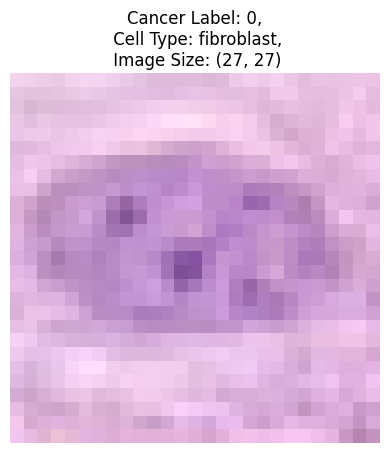

In [51]:
#fetching a single sample (e.g., for index 0)
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  # This must be a PIL Image object
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']
#displaying the image
if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

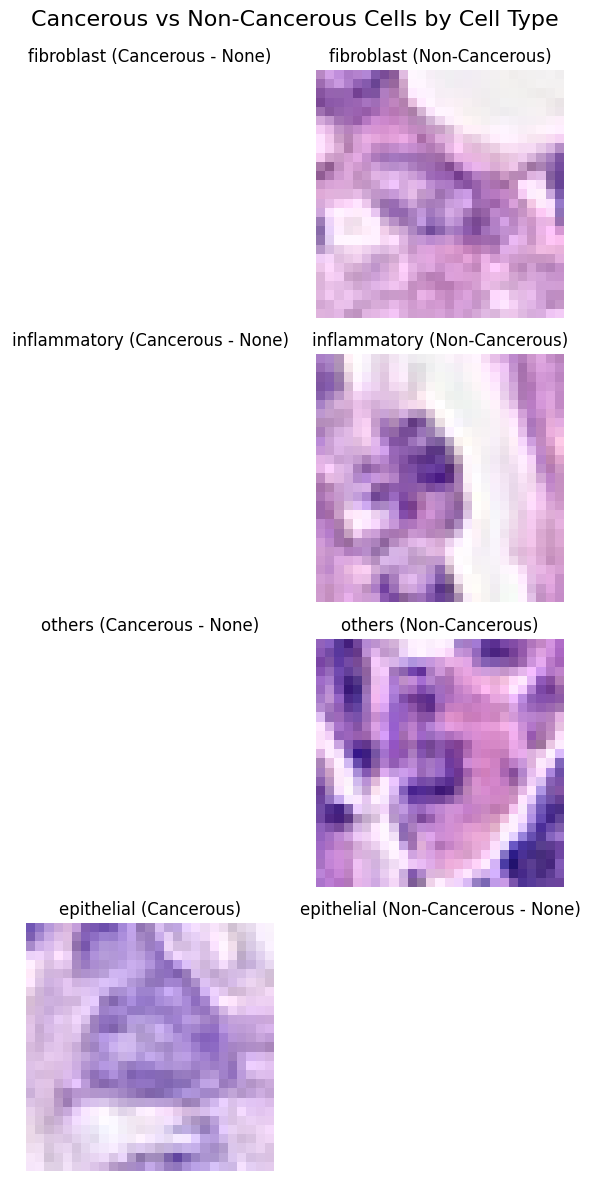

In [52]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()
#preparing the figure
fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))
#ensure axes is 2D
if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)
#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')
    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

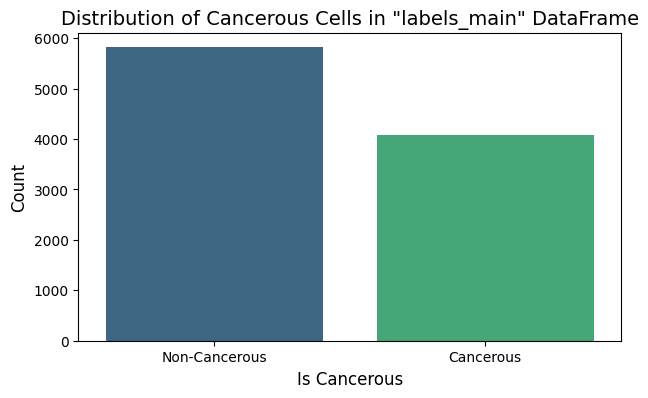

In [53]:
# Plotting the distribution of the 'isCancerous' label
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Adjust according to your label values
# Show the plot
plt.show()

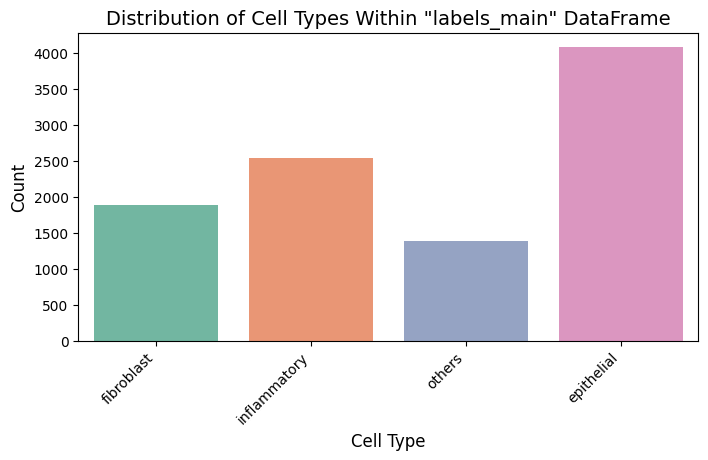

In [ ]:
#plotting the distribution of the 'cellTypeName' label (consistent with 'cellType')
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
#adding titles and labels
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [55]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
#optionally, you can filter columns with missing values only
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


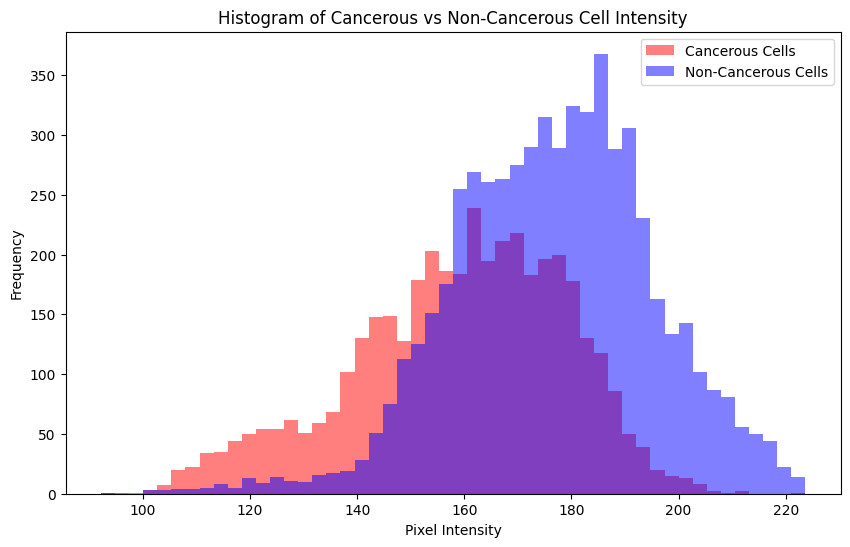

In [56]:
#defining function to calculate pixel intensity from an 'Image' object
def calculate_pixel_intensity(image_obj):
    #converting image to grayscale
    img_gray = image_obj.convert('L')  #'L' mode is for grayscale images
    #getting the pixel values as a numpy array
    pixel_values = np.array(img_gray)
    #calculating the average pixel intensity
    avg_intensity = pixel_values.mean()
    return avg_intensity

#filtering cancerous and non-cancerous cells from the DataFrame
cancerous_cells = labels_main[labels_main['isCancerous'] == 1].copy()
noncancerous_cells = labels_main[labels_main['isCancerous'] == 0].copy()
#applying the pixel intensity calculation function to each image in the 'Image' column
cancerous_cells.loc[:, 'pixel_intensity'] = cancerous_cells['Image'].apply(calculate_pixel_intensity)
noncancerous_cells.loc[:, 'pixel_intensity'] = noncancerous_cells['Image'].apply(calculate_pixel_intensity)

#extracting the pixel intensities as numpy arrays
cancerous_intensity = cancerous_cells['pixel_intensity'].values
noncancerous_intensity = noncancerous_cells['pixel_intensity'].values
#ensuring they are numpy arrays of floats for histogram calculation
cancerous_intensity = np.array(cancerous_intensity, dtype=float)
noncancerous_intensity = np.array(noncancerous_intensity, dtype=float)

#computing histograms
counts_cancer, bins = np.histogram(cancerous_intensity, bins=50)
counts_non_cancer, _ = np.histogram(noncancerous_intensity, bins=bins)

#plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(cancerous_intensity, bins=bins, alpha=0.5, color='red', label='Cancerous Cells')
plt.hist(noncancerous_intensity, bins=bins, alpha=0.5, color='blue', label='Non-Cancerous Cells')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Cancerous vs Non-Cancerous Cell Intensity')
plt.show()

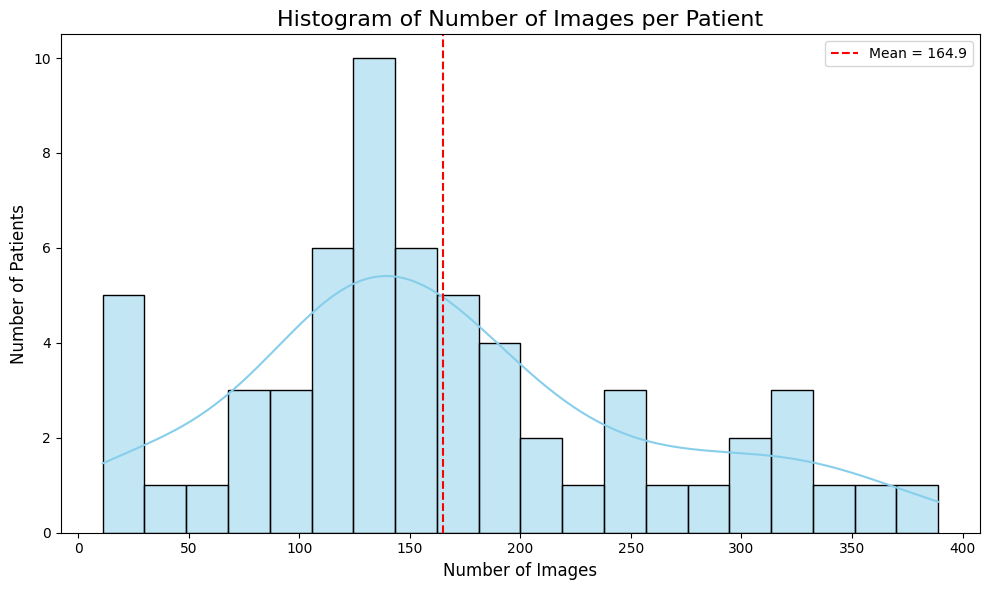

In [57]:
#counting the number of images per 'patientID'
patient_distribution = labels_main['patientID'].value_counts()
#plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(patient_distribution, bins=20, kde=True, color='skyblue')
#plotting mean line
mean_val = patient_distribution.mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.title('Histogram of Number of Images per Patient', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12) #number of patients that fall within each range
plt.legend()
plt.tight_layout()
plt.show()

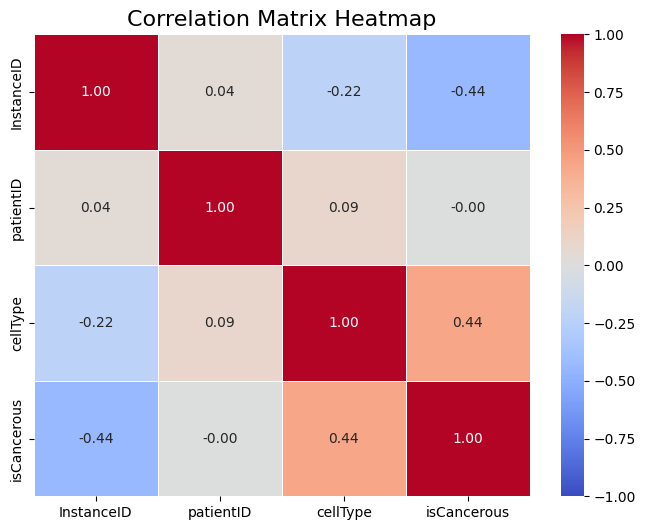

In [58]:
#selecting only numerical features from DataFrame
numerical_features = labels_main.select_dtypes(include=['float64', 'int64'])
#computing and plotting correlation matrix
corr_matrix = numerical_features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### *EDA Observations of `labels_main` DataFrame*

- **Dimensions of Dataset**: `labels_main` contains 9,896 rows and 7 columns, a moderately-sized dataset on colon cell histopathologies that may require memory management when training a model.

- **Revealing Data Types and Unique Value Counts**: 

    - Each `InstanceID` appears once so there are 9,896 unique instances of cell histopathologies. --> `int64` data type indicates all values are integers, representing unique instance ID given to each histopathology.
    - `patientID` has 60 unique values, with patient 54 appearing 389 times, indicating that multiple colon cell histopathologies were taken from the same patient, and some more than others. --> `int64` indicates all values are integers, representing unique ID given to each patient. 
    - `ImageName` have string values like `22405.pg` occurring once within `labels_main`. --> `object` data type indicates string values, representing unique image file names.

    - **Target Variables**
    - `cellTypeName` has 4 unique string values indicating a categorical variable = `epithelial`, `inflammatory`, `fibroblast`, `others`; `epithelial` appears twice as much as the next most frequently occuring category, showing that there is a significant class imbalance within this column. --> `object` data type as categories appear as strings (name of colon cell type).
    - `cellType` is the numerical representation of `cellTypeName`, ranging from 0 to 3, the inclusion of this feature is beneficial for model training because `cellTypeName` will not have to be converted to a numerical representation. Mapping `cellType` to `cellTypeName` demonstrates numerical representations are consistent with the text representation, where 0 == fibroblast, 1 == inflammatory, 2 == others, 3 = epithelial. --> `int64` data type.
    - `isCancerous` has two unique binary values, 0 (non-cancerous, 5817 instances) and 1 (cancerous, 4079 instances), with more values for non-cancerous colon cells, indicating a class imbalance. --> `int64` data type indicates that presence of cancer is represented by binary classification labels 0 and 1.

- **Evaluating Numerical Features**
    - `InstanceID` is wide-ranging from 1 to 22444, indicating missing IDs, this indicated that this data is not sequential, just a unique identifier for each colon cell histopathology (most likely not useful for modelling).
    - There are multiple samples given per `patientID`, some more than others, indicated by the mean = 29.8 and standard deviation = 17.5, indicating a moderately evenly distribution. Patient-level stratification may be required in model training to avoid data leakage.
    - `cellType`
    - Observing a slight class imbalance within the `isCancerous` binary variable has mean = 0.41, indicating that there are are higher number of non-cancerous instances than cancerous instances. This requires certain resampling techniques in data pre-processing to address the class imabalance.

- **Image Discrepancy**: all image names given within labels_main exist within the `patch_images` folder, but there exists a significant number of extra images (10,384) within the folder, which may need to be filtered out to avoid any errors as they can not be used in supervised model training. These extra images may be linked to the `lables_extra` data set. 

- **Target Variable Analysis**
    - When mapping the number of entries per `cellTypeName` to its `isCancerous` label, cancerous colon cells are only associated with the `epithelial` cell, while all other cell types are non-cancerous, indicating that `cellTypeName` is a significant predictor for detecting cancer in a colon cell. This also indicates that the data set is heavily biased to certain colon cell types. But including `cellTypeName` in model training might cause data leakage, as models can then trivially predict `isCancerous` label. Both target variables may need to be excluded from the other's model training.

- **Inspection of Sample Image**
    - The randomly selected image has 27x27 pixels, indicating that images in the dataset may be very small and have low resolution (as shown by the blurry image). There may need to be resizing in data pre-processing to ensure the model is able to process the images.
    - When observing the randomly selected image for each `cellTypeName` and `isCancerous` label, again you can observe the class imbalance as `fibroblast`, `inflammatory`, and `others` histopathologies appears in non-cancerous sample images, and `epithelial` only appears in cancerous ones. This reveals the imbalance in the data.
    - When observing the differences between cancerous and non-cancerous cells, non-cancerous cells appear to have less dark matter while the cancerous sample appears to have mostly dark matter. But visually, it is difficult to really differentiate as we do not have the opposing sample for each `cellTypeName`, making it harder to distinguish visually. 
    - This reinforces the need to exclude or specifically handle `cellTypeName` when predicting for `isCancerous` as the chance of overfitting and data leakage is high, as `cellTypeName` and `isCancerous` seem to be perfectly correlated in this dataset.

- **Distribution of `isCancerous`**: the data set is slightly skewed towards non-cancerous samples, and required resampling techniques to avoid bias and increase accuracy in model training. Once agian, it reveals the class imbalance.

- **Distribution of `cellTypeName`**: the `epithelial` colon cell histopathologies dominate the other cell types, once again revealing risk of overfitting and data leakage, due to high class imbalance.

- **Missing Values**: All columns in `labels_main` have no missing values, so there is no need for any missing value handling in data pre-processing.

- **Pixel Intensity Distribution**: 
    - The pixel intensity distribution histograms of the colon cell histopathologies for `isCancerous` == 1 vs. `isCancerous` == 0, both distributions are roughly bell-shaped, indicating that both are normally distributed. 
    - Cancerous cells tend to have lower pixel intensities (peaking around 160), while non-cancerous cells have relatively higher intensities (peaking around 180). 
    - Despite there being some overlap of intensities between cancerous vs. non-cancerous, the cancerous cells occur less frequently at these higher intensities.
    - This clear distinction in pixel intensity could be a predictive factor for the classification model to differentiate between cancerous and non-cancerous histopathologies.

- **Distribution of Images Per Patient**:
    - Histogram indicates that patient distribution is not normally distributed, no clear bell-shape, but it does indicate a slight right skew.
    - Reinforces the need for stratified sampling, some patients have contributed more colon cell histopathologies than others (>250), but these patients are less frequently occuring.
    - Average number of images per patient is 164.9, but most patients fall under this line, indicating a heavily imbalanced distribution.

- **Correlation Matrix Heatmap of Numerical Features**:
    - The heatmap indicates that `cellType` has a moderate positive correlation (0.44) with `isCancerous`, which means that it could be a significant predictor for `isCancerous` label in the classification model. But as discussed before, it may be incur too much bias and trivial predictions due to class imbalance. 
    - `InstanceID` being an identifier may mean it is not very meaningful for prediction (despite having -0.44 moderate negative correlation with `isCancerous`).
    - `patientID` also being an identifier has near-zero correlation with all features, again, not meaningful for prediction.

### *Class Imbalance Identification*

- **Class Imbalance in `cellTypeName`/`cellType`**: between the 4 classes of colon cell types represented in the histopathologies: fibroblast (0), inflammatory (1), others (2), and epithelial (3), there is significant class imbalance as epithelial appears twice as more as the next most frequently occuring cell type class. Typically this would indicate need for resampling during data pre-processing, but since it is observed to have perfect correlation with `isCancerous` due to huge gaps in data, `cellTypeName` and `cellType` may need to be excluded as a feature in the classification model for `isCancerous` (and vice versa) to avoid data leakage, overfitting, and trivial predictions.

- **Binary Imbalance in `isCancerous`**: there is nearly 1,800 more samples for non-cancerous (5,817) colon cell histopathologies than cancerous ones (4,079), though is not a significant imbalance, this requires use of resampling techniques or class weighting in data pre-processing. 

- **Distributional Imbalance in `patientID`**: certain patients have disproportionately contributed more colon cell histopathology samples than others, revealing an imbalanced representation of patients, this could lead overfitting as models learn patient-specific patterns and not general patterns. Patient-level stratification will be required when splitting the data in data pre-processing to prevent data leakage.

___
## II. Data Pre-processing

In [27]:
"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""




import os
import numpy as np
import pandas as pd
from PIL import Image

# Lists to store the data
X_task1 = []
y_isCancerous = []

X_task2 = []
y_cellType = []

# Combine only the isCancerous labels for Task 1
labels_task1 = pd.concat([labels_main, labels_extra], ignore_index=True)

# Use only main labels for Task 2 (cellType)
labels_task2 = labels_main.copy()

# Build separate dictionaries for fast lookup
labels_dict_task1 = labels_task1.set_index('ImageName').to_dict('index')
labels_dict_task2 = labels_task2.set_index('ImageName').to_dict('index')

# Load and preprocess images
for img_name in images_filtered:

    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  # Ensure all images are 27x27
        img_array = np.array(img) / 255.0  # Normalize pixel values (0-1)
        
        # Add to Task 1 (isCancerous)
        if img_name in labels_dict_task1:
            X_task1.append(img_array)
            y_isCancerous.append(labels_dict_task1[img_name]['isCancerous'])
        
        # Add to Task 2 (cellType) only if it has a cellType label
        if img_name in labels_dict_task2:
            X_task2.append(img_array)
            y_cellType.append(labels_dict_task2[img_name]['cellType'])
        
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# Convert to numpy arrays
X_task1 = np.array(X_task1)
y_isCancerous = np.array(y_isCancerous)

X_task2 = np.array(X_task2)
y_cellType = np.array(y_cellType)

print(f"Task 1 (isCancerous) - X shape: {X_task1.shape}, y shape: {y_isCancerous.shape}")
print(f"Task 2 (cellType) - X shape: {X_task2.shape}, y shape: {y_cellType.shape}")

Task 1 (isCancerous) - X shape: (9896, 27, 27, 3), y shape: (9896,)
Task 2 (cellType) - X shape: (9896, 27, 27, 3), y shape: (9896,)


In [28]:
# Encoding the labels for cell types
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

#encoding for task 1

y_isCancerous = np.array(y_isCancerous)
print(f"Task 1 (isCancerous) labels shape: {y_isCancerous.shape}") #it is already binary so no need to encode

#encoding for task 2

# Initialize label encoder
le = LabelEncoder()

# Integer encoding
y_cellType_encoded = le.fit_transform(y_cellType)

# One-hot encoding for multiclass classification
y_cellType_encoded = to_categorical(y_cellType_encoded)

print(f"Task 2 (cellType) labels shape: {y_cellType_encoded.shape}")
print(f"Cell type classes: {le.classes_}")

Num GPUs Available: 1
Task 1 (isCancerous) labels shape: (9896,)
Task 2 (cellType) labels shape: (9896, 4)
Cell type classes: [0 1 2 3]


In [29]:
# Preserving encoding order for future reference
# Store the classes for later use
cell_type_classes = le.classes_

# Save this to a file for reuse
np.save("cell_type_classes.npy", cell_type_classes)

print("Cell Type Classes (Preserved):", cell_type_classes)

# Load the saved classes (when needed)
loaded_classes = np.load("cell_type_classes.npy")
print("Loaded Cell Type Classes:", loaded_classes)

# Mapping prediction back to cell types

# Example: Decoding a single prediction
# predicted_class_index = 2  # Let's say the model predicts class index 2
# predicted_class_name = loaded_classes[predicted_class_index]
# print("Predicted Cell Type:", predicted_class_name)

Cell Type Classes (Preserved): [0 1 2 3]
Loaded Cell Type Classes: [0 1 2 3]


### Class Imbalance Check

C:\Users\Munim\AppData\Local\Temp\ipykernel_24060\1132786360.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))


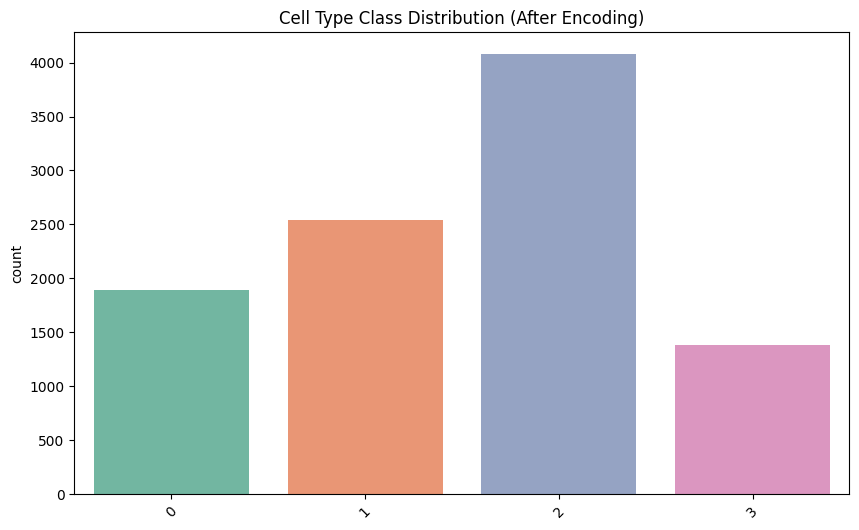

C:\Users\Munim\AppData\Local\Temp\ipykernel_24060\1132786360.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])


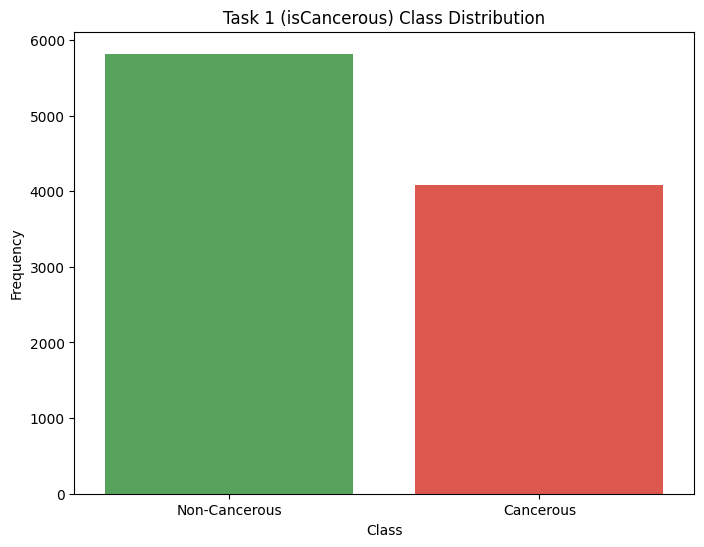

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert one-hot encoded back to integer for visualization
y_cellType_int = np.argmax(y_cellType_encoded, axis=1)

# Plot the distribution

# Define a color palette with as many colors as unique cell types
colors = sns.color_palette("Set2", len(cell_type_classes))

plt.figure(figsize=(10, 6))
sns.countplot(x=y_cellType_int, palette=colors, order=range(len(cell_type_classes)))
plt.title("Cell Type Class Distribution (After Encoding)")
plt.xticks(ticks=range(len(cell_type_classes)), labels=cell_type_classes, rotation=45)
plt.show()


# Plot distribution for isCancerous

colors = ['#4CAF50', '#F44336'] # Green for Non-Cancerous, Red for Cancerous
plt.figure(figsize=(8, 6))
sns.countplot(x=y_isCancerous, palette=colors, order=[0, 1])
plt.title("Task 1 (isCancerous) Class Distribution")
plt.xticks(ticks=[0, 1], labels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [31]:
# Save data for label mappings for later use
# Save the label mappings for reference
cell_type_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Cell Type Mapping:", cell_type_mapping)

# Final check on data shapes
print(f"Final X_task1 shape: {X_task1.shape}")
print(f"Final y_isCancerous shape: {y_isCancerous.shape}")
print(f"Final X_task2 shape: {X_task2.shape}")
print(f"Final y_cellType_encoded shape: {y_cellType_encoded.shape}")

Cell Type Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Final X_task1 shape: (9896, 27, 27, 3)
Final y_isCancerous shape: (9896,)
Final X_task2 shape: (9896, 27, 27, 3)
Final y_cellType_encoded shape: (9896, 4)


### *Rationale for Data Pre-processing Methods*

- 



### Train-Test Split

In [32]:
"""Since it is a patient-based dataset, splitting randomly may lead to data leakages,
to tacke this, we will split the data based on patient IDs
The training, validation, and testing sets has split ratios of 80%, 10%, and 10% respectively.

For the splitting stratified sampling is used to ensure that the distribution of the labels is similar in all sets.
The strafication is done based on patient IDs, so that all images from a single patient are in the same set.
"""



# Extract patient IDs from the dataset

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Extract patient IDs for each task
patient_ids_task1 = [name.split('_')[0] for name in labels_task1['ImageName']]
patient_ids_task2 = [name.split('_')[0] for name in labels_task2['ImageName']]

# Get unique patient IDs
unique_patients_task1 = np.unique(patient_ids_task1)
unique_patients_task2 = np.unique(patient_ids_task2)

print(f"Unique patients in Task 1: {len(unique_patients_task1)}")
print(f"Unique patients in Task 2: {len(unique_patients_task2)}")




# Split the unique patient IDs into training and testing sets

# Task 1 (isCancerous) - Split patients
train_patients_task1, test_patients_task1 = train_test_split(unique_patients_task1, test_size=0.2, random_state=42)
train_patients_task1, val_patients_task1 = train_test_split(train_patients_task1, test_size=0.2, random_state=42)

# Task 2 (cellType) - Split patients
train_patients_task2, test_patients_task2 = train_test_split(unique_patients_task2, test_size=0.2, random_state=42)
train_patients_task2, val_patients_task2 = train_test_split(train_patients_task2, test_size=0.2, random_state=42)



# Group images by patient IDs

# Task 1 (isCancerous)
X_train_task1, y_train_task1 = [], []
X_val_task1, y_val_task1 = [], []
X_test_task1, y_test_task1 = [], []

for i, img in enumerate(X_task1):
    patient_id = labels_task1.iloc[i]['ImageName'].split('_')[0]
    
    if patient_id in train_patients_task1:
        X_train_task1.append(img)
        y_train_task1.append(y_isCancerous[i])
    elif patient_id in val_patients_task1:
        X_val_task1.append(img)
        y_val_task1.append(y_isCancerous[i])
    elif patient_id in test_patients_task1:
        X_test_task1.append(img)
        y_test_task1.append(y_isCancerous[i])

# Task 2 (cellType)
X_train_task2, y_train_task2 = [], []
X_val_task2, y_val_task2 = [], []
X_test_task2, y_test_task2 = [], []

for i, img in enumerate(X_task2):
    patient_id = labels_task2.iloc[i]['ImageName'].split('_')[0]
    
    if patient_id in train_patients_task2:
        X_train_task2.append(img)
        y_train_task2.append(y_cellType_encoded[i])
    elif patient_id in val_patients_task2:
        X_val_task2.append(img)
        y_val_task2.append(y_cellType_encoded[i])
    elif patient_id in test_patients_task2:
        X_test_task2.append(img)
        y_test_task2.append(y_cellType_encoded[i])

# Convert to numpy arrays
X_train_task1 = np.array(X_train_task1)
X_val_task1 = np.array(X_val_task1)
X_test_task1 = np.array(X_test_task1)
y_train_task1 = np.array(y_train_task1)
y_val_task1 = np.array(y_val_task1)
y_test_task1 = np.array(y_test_task1)

X_train_task2 = np.array(X_train_task2)
X_val_task2 = np.array(X_val_task2)
X_test_task2 = np.array(X_test_task2)
y_train_task2 = np.array(y_train_task2)
y_val_task2 = np.array(y_val_task2)
y_test_task2 = np.array(y_test_task2)

# Print the final shapes
print(f"Task 1 - Train: {X_train_task1.shape}, Val: {X_val_task1.shape}, Test: {X_test_task1.shape}")
print(f"Task 2 - Train: {X_train_task2.shape}, Val: {X_val_task2.shape}, Test: {X_test_task2.shape}")

Unique patients in Task 1: 20280
Unique patients in Task 2: 9896
Task 1 - Train: (6372, 27, 27, 3), Val: (1586, 27, 27, 3), Test: (1938, 27, 27, 3)
Task 2 - Train: (6332, 27, 27, 3), Val: (1584, 27, 27, 3), Test: (1980, 27, 27, 3)


### *Data Splitting Strategy*

- 



___
## III. Building Baseline Model

### *Baseline Model Selection and Justification*

- 



Baseline Model 1: CNN

In [33]:
# Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation



baseline_cnn_task1 = Sequential()

# One convolutional block only
baseline_cnn_task1.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
baseline_cnn_task1.add(Activation('sigmoid'))
baseline_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense
baseline_cnn_task1.add(Flatten())
baseline_cnn_task1.add(Dense(1))
baseline_cnn_task1.add(Activation('sigmoid'))

optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed

# Compile
baseline_cnn_task1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Model summary
baseline_cnn_task1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4609      
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                      

In [34]:
#Train the Model
# Training
history_task1 = baseline_cnn_task1.fit(X_train_task1, y_train_task1,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation

Epoch 1/30
160/160 [==============================] - 3s 16ms/step - loss: 0.6553 - accuracy: 0.6325 - val_loss: 0.6463 - val_accuracy: 0.6039
Epoch 2/30
160/160 [==============================] - 2s 10ms/step - loss: 0.5661 - accuracy: 0.7083 - val_loss: 0.6999 - val_accuracy: 0.5239
Epoch 3/30
160/160 [==============================] - 2s 10ms/step - loss: 0.5202 - accuracy: 0.7379 - val_loss: 0.7780 - val_accuracy: 0.5098
Epoch 4/30
160/160 [==============================] - 2s 9ms/step - loss: 0.4903 - accuracy: 0.7599 - val_loss: 0.6365 - val_accuracy: 0.6071
Epoch 5/30
160/160 [==============================] - 2s 10ms/step - loss: 0.4730 - accuracy: 0.7667 - val_loss: 0.5340 - val_accuracy: 0.7247
Epoch 6/30
160/160 [==============================] - 2s 10ms/step - loss: 0.4305 - accuracy: 0.8038 - val_loss: 0.4863 - val_accuracy: 0.7671
Epoch 7/30
160/160 [==============================] - 2s 10ms/step - loss: 0.4182 - accuracy: 0.8117 - val_loss: 0.4248 - val_accuracy: 0.8220


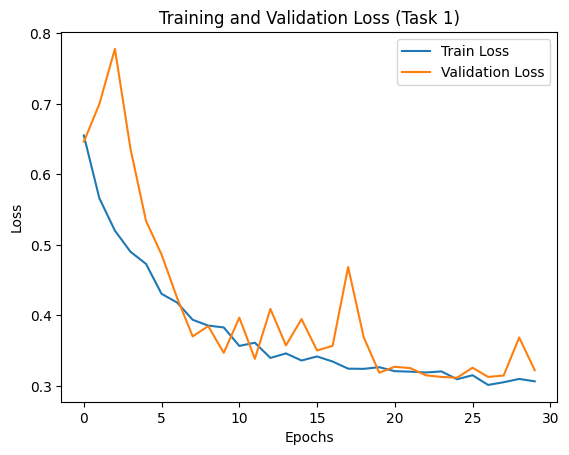

In [35]:
import matplotlib.pyplot as plt

# # Accuracy Plot
# plt.plot(history_task1.history['accuracy'], label='Train Accuracy')
# plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy (Task 1)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Loss Plot
plt.plot(history_task1.history['loss'], label='Train Loss')
plt.plot(history_task1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Evaluate on Validation Set
test_loss, test_accuracy = baseline_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


# Final Evaluation
# test_loss, test_accuracy = baseline_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

50/50 [==============================] - 0s 7ms/step - loss: 0.2921 - accuracy: 0.8865
Test Accuracy (Task 1 - isCancerous): 0.8865


In [37]:
# from sklearn.metrics import confusion_matrix, classification_report

# # Predict
# y_pred_task1 = (baseline_cnn_task1.predict(X_test_task1) > 0.5).astype("int32")

# # Confusion matrix
# cm = confusion_matrix(y_test_task1, y_pred_task1)
# print("Confusion Matrix:\n", cm)

# # Classification report
# print(classification_report(y_test_task1, y_pred_task1))

## Improving CNN Model from Baseline Task-1 (Binary Classification)

In [38]:
# Improved Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import RMSprop



#Convulutional block 1

improved_cnn_task1 = Sequential()
improved_cnn_task1.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27,27,3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))



#Convulutional block 2
improved_cnn_task1.add(Conv2D(64, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task1.add(Conv2D(128, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
# Optional: pooling after third conv
# improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

# #Convulutional block 4
# improved_cnn_task1.add(Conv2D(256, (3, 3)))
# improved_cnn_task1.add(Activation('relu'))



#start multiple layers

improved_cnn_task1.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task1.add(Dense(64))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task1.add(Dense(1))  # Output layer for binary classification
improved_cnn_task1.add(Activation('sigmoid'))  # Sigmoid activation for binary classification

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model summary
improved_cnn_task1.summary()


# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


optimizer = Adam(learning_rate=0.0001)

# optimizer = RMSprop(learning_rate=0.0005)

# optimizer = RMSprop(learning_rate=0.0001, decay=1e-6, momentum=0.9)


improved_cnn_task1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# improved_cnn_task1.compile(loss='binary_crossentropy',
#                            optimizer='sgd',
#                            metrics=['accuracy'])



## Some comments 
""" Reducing one maxpooling layer increased the accuracy of the model.
    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.
    Adam optimizer with learning rate of 0.0001 is giving good results."""

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

' Reducing one maxpooling layer increased the accuracy of the model.\n    RMSprop optimizer with learning rate of 0.0005 is not giving good results however the accuracy was good but with lots of spike in the loss graph.\n    Adam optimizer with learning rate of 0.0001 is giving good results.'

In [39]:
# Improving CNN Model from Baseline 


"""Data augmentating did not improve the accuracy of the model."""

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task1, y_train_task1, batch_size=32)
val_generator = val_gen.flow(X_test_task1, y_test_task1, batch_size=32)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.6798
Epoch 1: val_loss improved from inf to 0.42948, saving model to best_model_task1.h5
200/200 [==============================] - 5s 20ms/step - loss: 0.5899 - accuracy: 0.6798 - val_loss: 0.4295 - val_accuracy: 0.8426
Epoch 2/20
198/200 [============================>.] - ETA: 0s - loss: 0.3847 - accuracy: 0.8411
Epoch 2: val_loss improved from 0.42948 to 0.32330, saving model to best_model_task1.h5
200/200 [==============================] - 3s 15ms/step - loss: 0.3843 - accuracy: 0.8412 - val_loss: 0.3233 - val_accuracy: 0.8798
Epoch 3/20
198/200 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.8674
Epoch 3: val_loss improved from 0.32330 to 0.30272, saving model to best_model_task1.h5
200/200 [==============================] - 3s 14ms/step - loss: 0.3355 - accuracy: 0.8672 - val_loss: 0.3027 - val_accuracy: 0.8782
Epoch 4/20
196/200 [============================>.] - ET

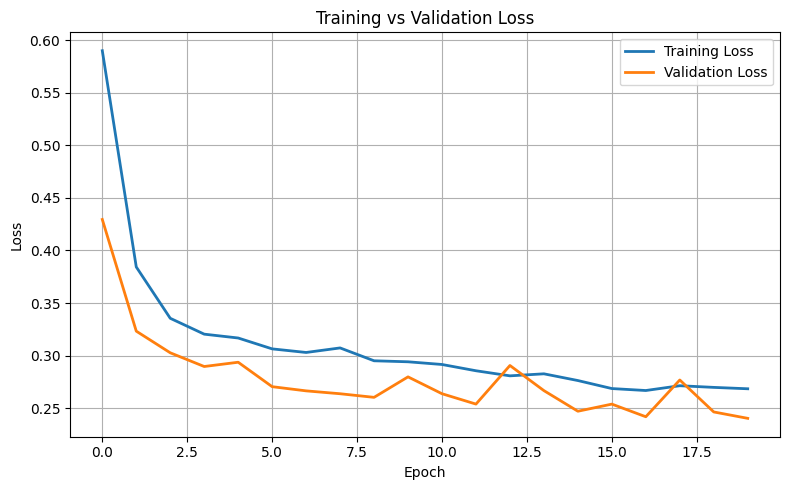

In [40]:
# history = improved_cnn_task1.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task1) // 32,
#     validation_steps=len(X_test_task1) // 32,
#     #callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Without augmentation

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task1.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)





history = improved_cnn_task1.fit(
    X_train_task1,
    y_train_task1,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_task1, y_test_task1),
    callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
)







import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)



# # Evaluate
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

In [41]:
# Final Evaluation
test_loss, test_accuracy = improved_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

# Final Evaluation
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

50/50 [==============================] - 0s 7ms/step - loss: 0.2522 - accuracy: 0.9048
Test Accuracy (Task 1 - isCancerous): 0.9048


## Task 2

### Baseline Model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

model_task2 = Sequential()

# Conv Block 1
model_task2.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
model_task2.add(Activation('sigmoid'))
model_task2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
# model_task2.add(Conv2D(64, (3, 3)))
# model_task2.add(Activation('relu'))
# Optional: skip pooling if accuracy drops

# Flatten and Dense
model_task2.add(Flatten())
model_task2.add(Dense(64))
model_task2.add(Activation('sigmoid'))
model_task2.add(Dropout(0.5))
model_task2.add(Dense(4))  # 4 classes
model_task2.add(Activation('softmax'))  # for multiclass

optimizer = Adam(learning_rate=0.0001)

# Compile
model_task2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_task2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_9 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                294976    
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                      

Epoch 1/30
159/159 [==============================] - 3s 13ms/step - loss: 1.3883 - accuracy: 0.3427 - val_loss: 1.1797 - val_accuracy: 0.6393
Epoch 2/30
159/159 [==============================] - 1s 8ms/step - loss: 1.3502 - accuracy: 0.3676 - val_loss: 1.2052 - val_accuracy: 0.6393
Epoch 3/30
159/159 [==============================] - 1s 8ms/step - loss: 1.3443 - accuracy: 0.3682 - val_loss: 1.1848 - val_accuracy: 0.6393
Epoch 4/30
159/159 [==============================] - 1s 9ms/step - loss: 1.3464 - accuracy: 0.3670 - val_loss: 1.1617 - val_accuracy: 0.6393
Epoch 5/30
159/159 [==============================] - 1s 7ms/step - loss: 1.3439 - accuracy: 0.3684 - val_loss: 1.2142 - val_accuracy: 0.6393
Epoch 6/30
159/159 [==============================] - 1s 7ms/step - loss: 1.3408 - accuracy: 0.3684 - val_loss: 1.1126 - val_accuracy: 0.6393
Epoch 7/30
159/159 [==============================] - 1s 8ms/step - loss: 1.3418 - accuracy: 0.3690 - val_loss: 1.1935 - val_accuracy: 0.6393
Epoch

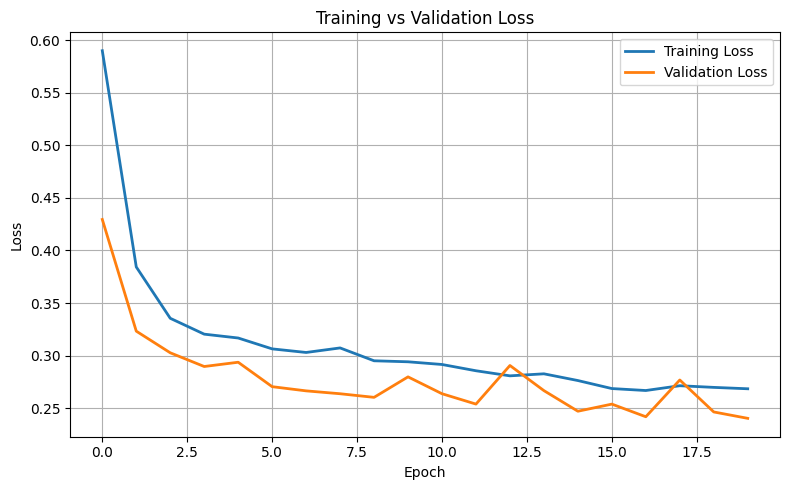

In [43]:
#Train the Model
# Training
history2 = model_task2.fit(X_train_task2, y_train_task2,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation



import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history2):
    plt.figure(figsize=(8,5))
    plt.plot(history2.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history2.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)

In [44]:
# Evaluate
test_loss, test_accuracy = model_task2.evaluate(X_test_task2, y_test_task2)
print(f"Test Accuracy (Task 2 - Cell Type): {test_accuracy:.4f}")

62/62 [==============================] - 0s 7ms/step - loss: 1.1005 - accuracy: 0.5990
Test Accuracy (Task 2 - Cell Type): 0.5990


## Devised Model for Task 2

In [63]:
# Improved Binary Classification Model for Task 2 (cellType)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 4 (classes for cell types)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers  # for layers like Conv2D, Dense, etc.
from tensorflow.keras import optimizers  # if using custom optimizers like SGD
from tensorflow.keras import regularizers  # for L2 regularization
from tensorflow.keras import callbacks  # for EarlyStopping, ModelCheckpoint, etc.
from tensorflow.keras import preprocessing  # for image preprocessing functions

from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import RMSprop



#Convulutional block 1

improved_cnn_task2 = Sequential()
improved_cnn_task2.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),strides=(1,1), input_shape=(27,27,3)))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))



#Convulutional block 2
improved_cnn_task2.add(Conv2D(64, (3, 3)))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task2.add(Conv2D(128, (3, 3)))
improved_cnn_task2.add(Activation('relu'))
# Optional: pooling after third conv
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 4
improved_cnn_task2.add(Conv2D(256, (3, 3)))
improved_cnn_task2.add(Activation('relu'))

# Optional: pooling after fourth conv
# improved_cnn_task2.add(MaxPooling2D(pool_size=(2, 2)))



#start multiple layers

improved_cnn_task2.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task2.add(Dense(64))
improved_cnn_task2.add(Activation('relu'))
improved_cnn_task2.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task2.add(Dense(4))  # Output layer for binary classification
improved_cnn_task2.add(Activation('softmax'))  # Softmax activation for multiclass classification

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# improved_cnn_task2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model summary
improved_cnn_task2.summary()


# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


optimizer = Adam(learning_rate=0.0001)

# optimizer = RMSprop(learning_rate=0.0005)

# optimizer = RMSprop(learning_rate=0.0001, decay=1e-6, momentum=0.9)


improved_cnn_task2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# improved_cnn_task2.compile(loss='binary_crossentropy',
#                            optimizer='sgd',
#                            metrics=['accuracy'])



## Some comments 
"""   """












Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 activation_36 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 activation_37 (Activation)  (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                 

'   '

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

# def resnet_block(x, filters, kernel_size=3):
#     shortcut = x

#     # First conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Second conv
#     x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)

#     # 🔧 Projection shortcut (only if needed)
#     if shortcut.shape[-1] != filters:
#         shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(shortcut)
#         shortcut = BatchNormalization()(shortcut)

#     # Add skip connection
#     x = Add()([x, shortcut])
#     x = Activation('relu')(x)
#     return x

# # Input layer
# input_layer = Input(shape=(27, 27, 3))

# # Initial conv
# x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(input_layer)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 1
# x = resnet_block(x, 32)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Residual block 2
# x = resnet_block(x, 64)

# # Flatten and dense head
# x = Flatten()(x)
# x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# # Output layer: 4 cell types
# output_layer = Dense(4, activation='softmax')(x)

# # Model
# resnet_model = Model(inputs=input_layer, outputs=output_layer)

# # Compile
# optimizer = Adam(learning_rate=0.0001)
# resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary
# resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 27, 27, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 32)  128         ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation_18 (Activation)     (None, 27, 27, 32)   0           ['batch_normalization[0][0]']

In [65]:

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task2.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [53]:
# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task2, y_train_task2, batch_size=32)
val_generator = val_gen.flow(X_test_task2, y_test_task2, batch_size=32)

Epoch 1/100
196/198 [============================>.] - ETA: 0s - loss: 1.2608 - accuracy: 0.4686
Epoch 1: val_loss improved from inf to 1.06943, saving model to best_model_task2.h5
198/198 [==============================] - 4s 14ms/step - loss: 1.2593 - accuracy: 0.4697 - val_loss: 1.0694 - val_accuracy: 0.5768
Epoch 2/100
191/198 [===========================>..] - ETA: 0s - loss: 0.9593 - accuracy: 0.6366
Epoch 2: val_loss improved from 1.06943 to 0.88829, saving model to best_model_task2.h5
198/198 [==============================] - 2s 10ms/step - loss: 0.9568 - accuracy: 0.6369 - val_loss: 0.8883 - val_accuracy: 0.6374
Epoch 3/100
192/198 [============================>.] - ETA: 0s - loss: 0.8581 - accuracy: 0.6725
Epoch 3: val_loss improved from 0.88829 to 0.86531, saving model to best_model_task2.h5
198/198 [==============================] - 2s 10ms/step - loss: 0.8566 - accuracy: 0.6734 - val_loss: 0.8653 - val_accuracy: 0.6682
Epoch 4/100
197/198 [============================>.] 

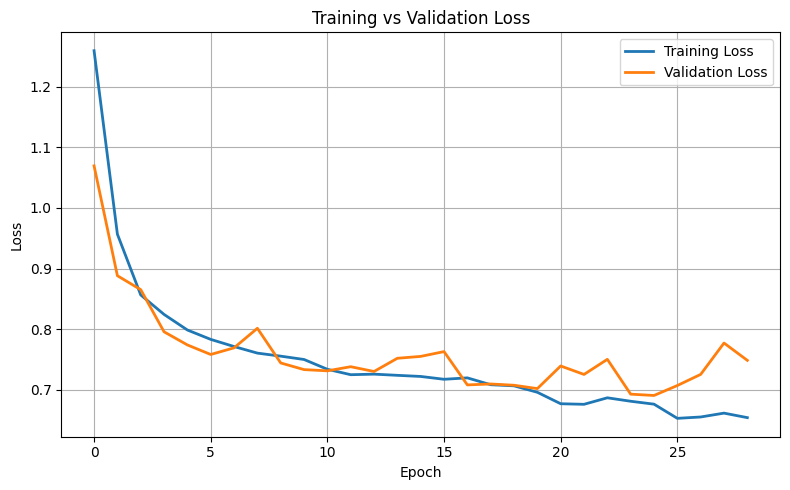

In [66]:

# Without augmentation

## ResNet Model Training

# history = resnet_model.fit(
#     X_train_task2,
#     y_train_task2,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test_task2, y_test_task2),
#     callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
# )

## CNN Model Training

history = improved_cnn_task2.fit(
    X_train_task2,
    y_train_task2,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_task2, y_test_task2),
    callbacks=[early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
)



# with Augmentation

#CNN
# history = improved_cnn_task2.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task2) // 32,
#     validation_steps=len(X_test_task2) // 32,
#     callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )

# ResNet
# history = resnet_model.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task2) // 32,
#     validation_steps=len(X_test_task2) // 32,
#     callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


import matplotlib.pyplot as plt

# Example history object assumed to be named `history`
# This function will work only if `history` is defined and contains `loss` and `val_loss`

def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Attempt to plot assuming history variable is available in user's environment
try:
    plot_loss(history)
except Exception as e:
    str(e)



# # Evaluate
# test_loss, test_accuracy = improved_cnn_task1.evaluate(X_test_task1, y_test_task1)
# print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

In [67]:
# Evaluate
test_loss, test_accuracy = improved_cnn_task2.evaluate(X_test_task2, y_test_task2)
print(f"Test Accuracy (Task 2 - Cell Type): {test_accuracy:.4f}")

62/62 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.7338
Test Accuracy (Task 2 - Cell Type): 0.7338


## Semi Supervised Learning 

In [68]:
# Load the trained model

from tensorflow.keras.models import load_model

#Load the trained model for task 2 (CellType)

semi_supervised_model_task2 = load_model('best_model_task2.h5')

In [72]:
# Function to load images from the extra dataset
def load_images_extra(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        # Add .png extension if not present
        if not img_name.endswith(".png"):
            img_name += ".png"
            
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images

# Loading the images for the extra dataset
image_objects_extra = load_images_extra(image_folder, labels_extra['ImageName'])

# Adding a new column 'Image' to labels_extra
labels_extra['Image'] = labels_extra['ImageName'].map(image_objects_extra)

# Display the first few rows to confirm
labels_extra.head()


Error loading 12681.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_assignment2\\Image_classification_data\\images\\12681.png'
Error loading 12682.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_assignment2\\Image_classification_data\\images\\12682.png'
Error loading 12683.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_assignment2\\Image_classification_data\\images\\12683.png'
Error loading 12684.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_assignment2\\Image_classification_data\\images\\12684.png'
Error loading 12685.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_assignment2\\Image_classification_data\\images\\12685.png'
Error loading 12686.png: [Errno 2] No such file or directory: 'D:\\+Masters AI\\Semester_2_1\\CML\\Assignment-2\\cml_ass

,InstanceID,patientID,ImageName,isCancerous,Image
0,12681,61,12681.png,0,NaN
1,12682,61,12682.png,0,NaN
2,12683,61,12683.png,0,NaN
3,12684,61,12684.png,0,NaN
4,12685,61,12685.png,0,NaN
